# Artificial Neural Networks and Deep Learning - Homework 1

Team Name: **AneuralI**  
Members:  
- **Davide Corradina** (252117)  
- **Federico de Introna** (251274)  
- **Francesco Di Giore** (252126)  
- **Michele Leggieri** (244615)

---

## Introduction
In this notebook, we will build and fine-tune a deep learning model for image classification. The dataset consists of labeled images, each corresponding to one of eight different classes, such as Basophil, Eosinophil, Lymphocyte, and others. The task is to train a model that can accurately classify these images into their respective classes.

We will use a transfer learning approach with the ConvNeXtBase architecture, which has shown strong performance in image classification tasks. Additionally, we will apply several image augmentation techniques to improve the model’s generalization ability and handle class imbalance.

### Steps Involved
1. **Data Preparation**: Load and preprocess the dataset, ensuring proper handling of image formats and class labels.

2. **Data Augmentation**: Apply several augmentation strategies, such as RandAugment, CutMix, and MixUp, to generate diverse versions of the training images and reduce overfitting.

3. **Transfer Lerning and model building**: Fine-tune a pre-trained ConvNeXtLarge model on our dataset, leveraging transfer learning to speed up convergence.

4. **Tranfer Learning with Fine-Tuning**: Unfreeze some layers of the pre-trained model to perform further fine-tuning, improving the model's performance.

5. **Evaluation**: Use metrics like accuracy, precision, recall, and F1 score to assess model performance. Additionally, we will visualize the confusion matrix to better understand where the model makes errors.

---

## ⚙️ Import Libraries

In [ ]:
!pip install keras-cv

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
from tensorflow.keras import mixed_precision
import keras_cv

# Set random seeds for reproducibility
seed = 42
np.random.seed(42)
tf.random.set_seed(42);

# Configure Seaborn and Matplotlib for consistent, aesthetic plotting
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

%matplotlib inline  # Ensure inline plotting in Jupyter Notebooks

In [ ]:
BATCH_SIZE = 32 # Define batch size for training
AUTOTUNE = tf.data.AUTOTUNE # Enable automatic data optimization
NUM_CLASSES = 8

# Plot training and validation accuracy
def plot_hist(hist):
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# Visualize images from the dataset
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


## ⏳ Load the Data

In [ ]:
# Load dataset from cleaned .npz file
data = np.load('/kaggle/input/clean-dataset/clean_dataset.npz')

# Extract images and labels
X_train_val = data['images']
y_train_val = data['labels']

# Print dataset shapes
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Map label indices to class names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

Training-Validation Data Shape: (11953, 96, 96, 3)
Training-Validation Label Shape: (11953, 1)


In [ ]:
# Split data into training and validation sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=seed)

# Convert labels to one-hot encoding
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

In [ ]:
# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [ ]:
# Convert data to dictionary format with images and labels
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}

# Prepare dataset for training or testing
def prepare_dataset(dataset, split):
    return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# Load and prepare dataset
def load_dataset(dataset, split="train"):
    return prepare_dataset(dataset, split)

In [ ]:
# Load and prepare training and testing datasets
train_dataset1 = load_dataset(train_dataset, split="train")
test_dataset1 = load_dataset(test_dataset, split="test")

<_BatchDataset element_spec={'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}>

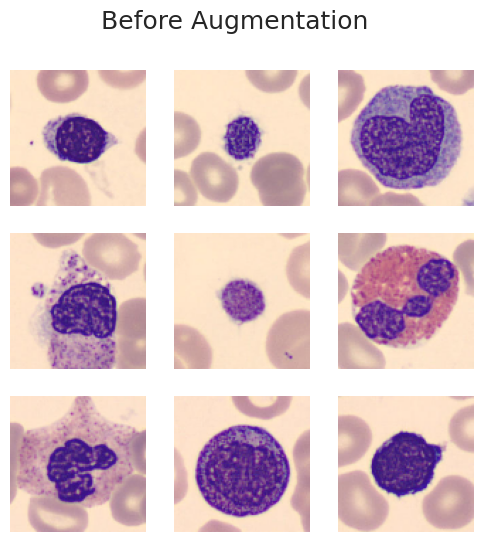

In [ ]:
visualize_dataset(train_dataset1, title="Before Augmentation")

In [ ]:
y_train_val = np.ravel(y_train_val) # Flatten label

# Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_val),  # Replace with actual class labels in y_train or y_train_val
    y=y_train_val
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Display computed class weights
print("Computed Class Weights:")
for class_label, weight in class_weights_dict.items():
    print(f"Class {class_label}: Weight {weight:.4f}")

Computed Class Weights:
Class 0: Weight 1.7557
Class 1: Weight 0.6857
Class 2: Weight 1.3771
Class 3: Weight 0.7386
Class 4: Weight 1.7599
Class 5: Weight 1.5047
Class 6: Weight 0.6413
Class 7: Weight 0.9094


In [ ]:
# Define augmentation layers for image preprocessing
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.3, magnitude_stddev=0.2
)

# Add custom augmentation layers to the pipeline
layers = layers + [keras_cv.layers.ChannelShuffle()]
layers = layers + [keras_cv.layers.JitteredResize((96,96), (0.9,1))]
layers = layers + [keras_cv.layers.RandomChannelShift(value_range=(0, 255), factor=0.5)]
layers = layers + [keras_cv.layers.RandomCutout(0.5, 0.5)]
layers = layers + [keras_cv.layers.RandomHue(factor=0.2, value_range=(0, 255))]
layers = layers + [keras_cv.layers.RandomSharpness(factor=0.2, value_range=(0, 255))]
layers = layers + [keras_cv.layers.GridMask()]

# Create augmentation pipelines
pipeline_2 = keras_cv.layers.RandomAugmentationPipeline(layers=layers, augmentations_per_image=2)
pipeline_1 = keras_cv.layers.RandomAugmentationPipeline(layers=layers, augmentations_per_image=1)

# Apply pipeline 2 (two augmentations) to inputs
def apply_pipeline_2(inputs):
    images = inputs["images"]
    images = tf.clip_by_value(images, 0.0, 255.0)
    inputs["images"] = pipeline_2(inputs["images"])
    images = tf.clip_by_value(images, 0, 255)
    return inputs

# Apply pipeline 1 (one augmentation) to inputs
def apply_pipeline_1(inputs):
    images = inputs["images"]
    images = tf.clip_by_value(images, 0.0, 255.0)
    inputs["images"] = pipeline_1(inputs["images"])
    images = tf.clip_by_value(images, 0, 255)
    return inputs

[<AutoContrast name=auto_contrast, built=False>,
 <Equalization name=equalization, built=False>,
 <Solarization name=solarization, built=False>,
 <RandomColorDegeneration name=random_color_degeneration, built=False>,
 <RandomContrast name=random_contrast, built=False>,
 <RandomBrightness name=random_brightness, built=False>,
 <RandomShear name=random_shear, built=False>,
 <RandomShear name=random_shear_1, built=False>,
 <RandomTranslation name=random_translation, built=False>,
 <RandomTranslation name=random_translation_1, built=False>,
 <ChannelShuffle name=channel_shuffle, built=False>,
 <JitteredResize name=jittered_resize, built=False>,
 <RandomChannelShift name=random_channel_shift, built=True>,
 <RandomCutout name=random_cutout, built=False>,
 <RandomHue name=random_hue, built=False>,
 <RandomSharpness name=random_sharpness, built=False>,
 <GridMask name=grid_mask, built=True>]

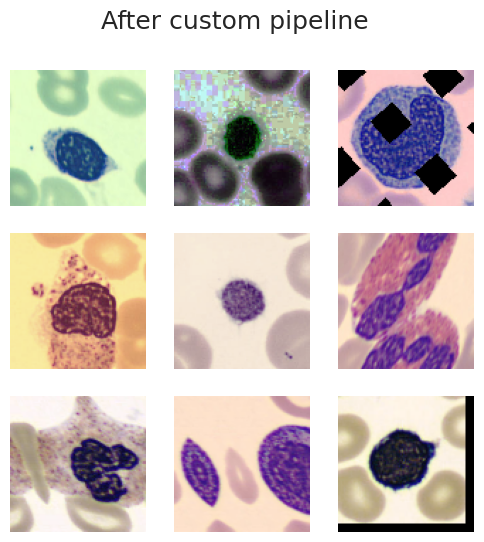

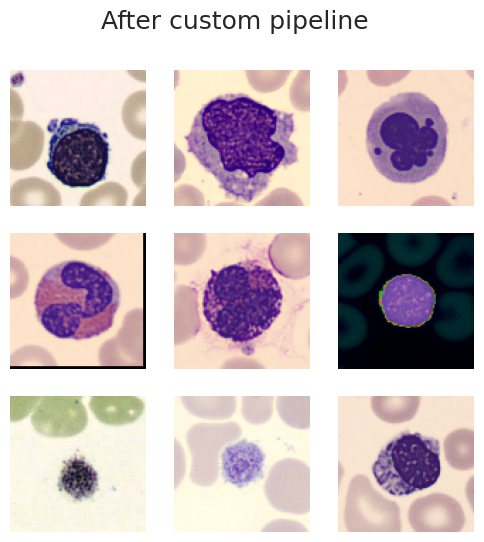

In [ ]:
# Apply augmentation pipelines to the datasets only for visualization
aug2_dataset = load_dataset(train_dataset).map(apply_pipeline_2, num_parallel_calls=AUTOTUNE)
aug_test = load_dataset(test_dataset).map(apply_pipeline_1, num_parallel_calls=AUTOTUNE)

# Visualize the augmented datasets
visualize_dataset(aug2_dataset, title="After custom pipeline")
visualize_dataset(aug_test, title="After custom pipeline")

In [ ]:
# Function to check if image values are within the valid range [0, 255]
def check_image_values(dataset):
    for i, samples in enumerate(iter(dataset.take(100))): #Check first 100 images
        images = samples["images"]
        for image in images:
            image_np = image.numpy()
            if np.min(image_np) < 0 or np.max(image_np) > 255:
                print(f"Image {i} has values outside the range [0, 255].")
                print(f"Min: {np.min(image_np)}, Max: {np.max(image_np)}")
                return
    print("All images in the dataset have values within the range [0, 255].")

# Check the image values in the augmented training dataset
check_image_values(aug2_dataset)

Image 28 has values outside the range [0, 255].
Min: 12.791369438171387, Max: 255.00001525878906


In [ ]:
# Initialize augmentation layers for CutMix, MixUp, and FourierMix
cut_mix = keras_cv.layers.CutMix() # CutMix augmentation layer
mix_up = keras_cv.layers.MixUp() # MixUp augmentation layer
fourier_mix = keras_cv.layers.FourierMix(0.5) # FourierMix with a factor of 0.5

# Apply CutMix and MixUp augmentations to the dataset
def cut_mix_and_mix_up(samples):
    samples['labels'] = tf.cast(samples['labels'], tf.float32)
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples

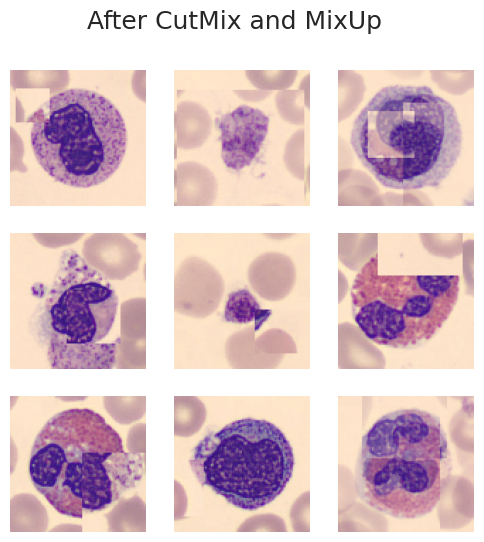

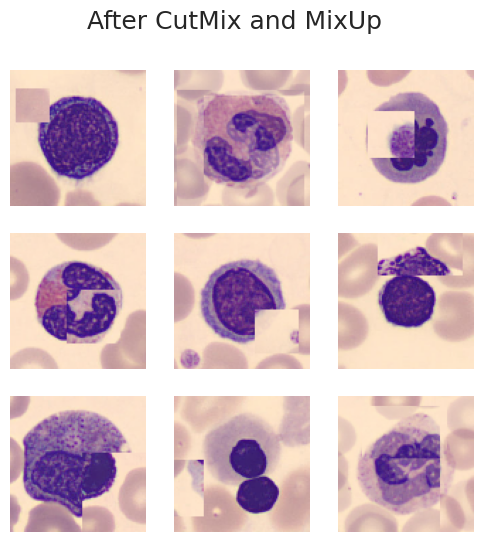

In [ ]:
# Apply CutMix and MixUp augmentations to the training and test datasets
train_dataset_cm = load_dataset(train_dataset).map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
test_dataset_cm = load_dataset(test_dataset).map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

# Visualize the augmented training and test datasets
visualize_dataset(train_dataset_cm, title="After CutMix and MixUp")
visualize_dataset(test_dataset_cm, title="After CutMix and MixUp")

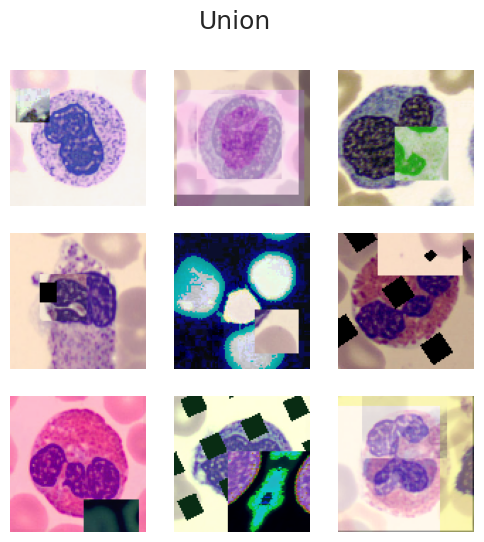

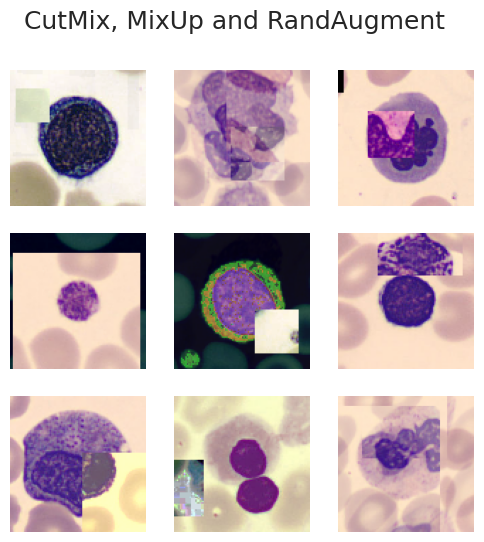

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [ ]:
# Preprocess the images and labels for the model
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

# Apply augmentation pipelines and CutMix/MixUp to the training datasets
train_dataset_processed_2 = (
    load_dataset(train_dataset)
    .map(apply_pipeline_2, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)
"""
train_dataset_processed_1 = (
    load_dataset(train_dataset)
    .map(apply_pipeline_1, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)
"""
test_dataset_processed = (
    load_dataset(test_dataset)
    .map(apply_pipeline_1, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

# Concatenate two processed training datasets
train_dataset_processed = train_dataset_processed_2.concatenate(train_dataset_processed_2)

# Visualize the combined training and test datasets
visualize_dataset(train_dataset_processed, title="Union")
visualize_dataset(test_dataset_processed, title="CutMix, MixUp and RandAugment")

# Prepare the training and test datasets for the model
ready_train_dataset = train_dataset_processed.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
ready_test_dataset = test_dataset_processed.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

# Shuffle and prefetch the datasets for efficient training
ready_train_dataset = ready_train_dataset.shuffle(1000).prefetch(AUTOTUNE)
ready_test_dataset = ready_test_dataset.shuffle(1000).prefetch(AUTOTUNE)

ready_test_dataset

## 🛠️ Train and Save the Model

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)
num_classes = 8

# Number of training epochs
epochs = 100

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 100
Batch Size: 64
Learning Rate: 0.001


## Current Model

In [ ]:
from keras.applications import ConvNeXtBase

# Set mixed precision policy for faster training on compatible hardware (for examples GPUs)
mixed_precision.set_global_policy('mixed_float16')

# Define input layer shape
input = tfk.Input(shape=input_shape, name='input_layer')

# Load the pre-trained ConvNeXtLarge model without the top (classification) layer
base_model = ConvNeXtBase(include_top=False, input_shape=input_shape, weights="imagenet")
base_model.trainable = False

# Pass the input through the base model
x = base_model(input)

# Add global average pooling to reduce spatial dimensions
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)

# Apply batch normalization (alternative: GroupNormalization)
x = tfkl.BatchNormalization()(x)

# Add dropout for regularization
top_dropout_rate = 0.2
x = tfkl.Dropout(top_dropout_rate, name="top_dropout")(x)

# Fully connected layers (dense layers)
x = tfkl.Dense(512, activation='relu', name='fc1')(x)
x = tfkl.Dense(256, activation='relu', name='fc2')(x)
x = tfkl.Dense(128, activation='relu', name='fc3')(x)
x = tfkl.Dense(64, activation='relu', name='fc4')(x)

# Add final dropout layer
x = tfkl.Dropout(0.25, name="end_dropout")(x)

# Output layer with softmax activation for multi-class classification
outputs = tfkl.Dense(num_classes, activation="softmax", name="pred")(x)

# Create the model
model = tfk.Model(input, outputs, name="ConvNeXtBaseTransfer")

# Compile the model with loss, optimizer, and evaluation metrics
model.compile(
        loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=tfk.optimizers.AdamW(tfk.optimizers.schedules.CosineDecayRestarts(1e-4, 1500)),
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.summary()

Model: "convnext_base"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 24, 24,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │      6,400 │ add[0][0]         │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 24, 24,    │        128 │ convnext_base_st

 Total params: 87,566,464 (334.04 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,566,464 (334.04 MB)

Epoch 1/100


I0000 00:00:1732134262.965925      96 service.cc:145] XLA service 0x5cb872302880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732134262.965975      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/598 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.2500 - loss: 2.1817 - precision: 0.0000e+00 - recall: 0.0000e+00    

I0000 00:00:1732134273.854707      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


598/598 ━━━━━━━━━━━━━━━━━━━━ 128s 85ms/step - accuracy: 0.4336 - loss: 1.7717 - precision: 0.8527 - recall: 0.0731 - val_accuracy: 0.5947 - val_loss: 1.5924 - val_precision: 0.9576 - val_recall: 0.1416
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - accuracy: 0.6385 - loss: 1.4168 - precision: 0.9202 - recall: 0.2162 - val_accuracy: 0.6123 - val_loss: 1.5732 - val_precision: 0.9699 - val_recall: 0.1540
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.6590 - loss: 1.3868 - precision: 0.9264 - recall: 0.2288 - val_accuracy: 0.6148 - val_loss: 1.5674 - val_precision: 0.9622 - val_recall: 0.1595
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.6739 - loss: 1.3416 - precision: 0.9397 - recall: 0.2518 - val_accuracy: 0.6278 - val_loss: 1.5352 - val_precision: 0.9617 - val_recall: 0.1746
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 80s 54ms/step - accuracy: 0.6795 - loss: 1.3273 - precision: 0.9394 - recall: 0.2457 - val_accuracy: 0.6378 - val_loss

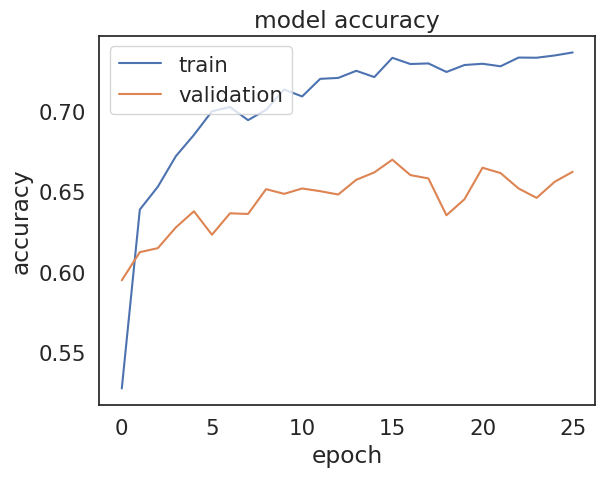

Final validation accuracy: 67.0%


In [ ]:
# Train the model using the training dataset and validate on the test dataset
history = model.fit(
    ready_train_dataset,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ready_test_dataset,
    class_weight = class_weights_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Plot the training and validation accuracy
plot_hist(history)

# Calculate the final validation accuracy and print the result
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

In [ ]:
# Function to unfreeze the ConvNeXt model layers and set certain layers as non-trainable
def unfreeze_model(model):
    tf_model = model.get_layer("convnext_large")
    tf_model.trainable = True
    model.get_layer("batch_normalization").trainable = False # Set BatchNormalization layers to non-trainable

    # Loop through layers of ConvNeXt and freeze certain layers
    for layer in tf_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization) or isinstance(layer, tf.keras.layers.LayerNormalization):
            layer.trainable = False
        if "layer_scale" in layer.name.lower():  # Match name case-insensitively
            layer.trainable = False

unfreeze_model(model)

# Recompile the model with a new optimizer and learning rate schedule
optimizer = tfk.optimizers.AdamW(tfk.optimizers.schedules.CosineDecayRestarts(1e-4, 1794))
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

model.summary()

for layer in base_model.layers: print(layer.name, layer.trainable)
for layer in model.layers: print(layer.name, layer.trainable)

Model: "ConvNeXtBaseTransfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 3, 3, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ end_dropout (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,268,360 (336.72 MB)

 Trainable params: 88,208,072 (336.49 MB)

 Non-trainable params: 60,288 (235.50 KB)

input_layer True
convnext_base_prestem_normalization True
convnext_base_stem True
convnext_base_stage_0_block_0_depthwise_conv True
convnext_base_stage_0_block_0_layernorm False
convnext_base_stage_0_block_0_pointwise_conv_1 True
convnext_base_stage_0_block_0_gelu True
convnext_base_stage_0_block_0_pointwise_conv_2 True
convnext_base_stage_0_block_0_layer_scale False
convnext_base_stage_0_block_0_identity True
convnext_base_stage_0_block_1_depthwise_conv True
convnext_base_stage_0_block_1_layernorm False
convnext_base_stage_0_block_1_pointwise_conv_1 True
convnext_base_stage_0_block_1_gelu True
convnext_base_stage_0_block_1_pointwise_conv_2 True
convnext_base_stage_0_block_1_layer_scale False
convnext_base_stage_0_block_1_identity True
convnext_base_stage_0_block_2_depthwise_conv True
convnext_base_stage_0_block_2_layernorm False
convnext_base_stage_0_block_2_pointwise_conv_1 True
convnext_base_stage_0_block_2_gelu True
convnext_base_stage_0_block_2_pointwise_conv_2 True
convnext_base_

In [ ]:
# Enable mixed precision training for faster computation and reduced memory usage
mixed_precision.set_global_policy('mixed_float16')

# Set the number of fine-tuning epochs
ft_epochs = 150

# Train the model with the fine-tuning dataset and configurations
history = model.fit(
    ready_train_dataset,
    batch_size = batch_size,
    epochs = ft_epochs,
    validation_data = ready_test_dataset,
    class_weight = class_weights_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate the final validation accuracy and print the result
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 400s 403ms/step - accuracy: 0.7619 - loss: 0.9308 - precision_1: 0.9308 - recall_1: 0.3384 - val_accuracy: 0.7599 - val_loss: 1.1315 - val_precision_1: 0.9907 - val_recall_1: 0.2179
Epoch 2/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 232s 311ms/step - accuracy: 0.8533 - loss: 0.6255 - precision_1: 0.9739 - recall_1: 0.4092 - val_accuracy: 0.7846 - val_loss: 1.0292 - val_precision_1: 0.9928 - val_recall_1: 0.2436
Epoch 3/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 233s 311ms/step - accuracy: 0.8685 - loss: 0.6008 - precision_1: 0.9865 - recall_1: 0.4056 - val_accuracy: 0.7637 - val_loss: 1.0769 - val_precision_1: 0.9881 - val_recall_1: 0.2264
Epoch 4/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 235s 310ms/step - accuracy: 0.8607 - loss: 0.6080 - precision_1: 0.9752 - recall_1: 0.4217 - val_accuracy: 0.7972 - val_loss: 0.9838 - val_precision_1: 0.9893 - val_recall_1: 0.2633
Epoch 5/150
598/598 ━━━━━━━━━━━━━━━━━━━━ 232s 310ms/step - accuracy: 0.8787 - loss: 0.5617 - precision_1: 0.

In [ ]:
# Display a summary of the model architecture
model.summary(expand_nested=True)

Model: "ConvNeXtBaseTransfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 3, 3, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_base_prestem_normaliz… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_base_stem         │ (None, 24, 24, 128)    │         6,528 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ convnext_base_stem_conv │ (None, 24, 24, 128)    │         6,272 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stem_layernorm    │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,400 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           256 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │        66,048 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 512)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │        65,664 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │           128 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (LayerScale)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │             0 │
│ convnext_base_stage_0_block_0_… │                        │               │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 128)    │         6,40

 Total params: 264,684,509 (1009.69 MB)

 Trainable params: 88,208,072 (336.49 MB)

 Non-trainable params: 60,288 (235.50 KB)

 Optimizer params: 176,416,149 (672.97 MB)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Make predictions on the test dataset
predictions = model.predict(ready_test_dataset, verbose=0)
print("Predictions Shape:", predictions.shape)

# Get predicted class labels (using argmax for categorical output)
pred_classes = np.argmax(predictions, axis=-1)

# Extract the true labels from the dataset (assuming labels are included in the dataset)
true_classes = np.concatenate([y for x, y in ready_test_dataset], axis=0)
true_classes = np.argmax(true_classes, axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
annot = np.array([f"{num}\n({num/np.sum(cm)*100:.2f}%)" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# To print the overall accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_classes, pred_classes)
precision = precision_score(true_classes, pred_classes, average='macro')
recall = recall_score(true_classes, pred_classes, average='macro')
f1 = f1_score(true_classes, pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'Homework1_'+str(final_val_accuracy)+'.keras'
model.save(model_filename, save_format='h5', include_optimizer=False)

In [ ]:
del model